# Group project

By delivering this notebook, we confirm that the group project was developed by the following students.

## Student 1: Rômulo Feijão Filho, 50530
## Student 2: Maria Ferreira, 50465


The group project will focus on analysing data on flights in the US.

Unless otherwise specified, the problems can be solved using either Spark or Pandas.

Some useful links:

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)


## Colab setup

The following cell will install Spark, if the notebook is running on COLAB. Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing)

In [1]:
#Run this cell to install Spark on Colab
import os

if 'COLAB_GPU' in os.environ : 
    !apt-get install openjdk-8-jdk-headless
    !pip install pyspark==3.1.2
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar -y
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.1-s_2.12.jar pyspark-shell'

    from google.colab import drive
    drive.mount('/content/drive')



## Local setup

For running the group project locally, you should create a directory named **data** in the directory where you have this notebook. Then, you should download to the **data** directory the files in the following link: [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing).

## Initialization

Import libraries. 

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors

plt.style.use('seaborn')

print(pyspark.__version__)


3.1.2


Let's start spark session and set *log* level to ERROR.

In [3]:

spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if 'COLAB_GPU' in os.environ : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.1-s_2.12.jar')
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.0-s_2.12.jar')


spark.sparkContext.setLogLevel("ERROR")

## Data selection

This cell controls the dataset you will be using. Note that this cell will control the path to the files, dependening on the platform you are using to run the code.


In [4]:
# Comment the following 
flightsF = "sample.csv"
# flightsF = "complete.csv"
#flightsF = "data-2009.csv"
#flightsF = "data-2010.csv"
#flightsF = "data-2011.csv"
#flightsF = "data-2012.csv"
#flightsF = "data-2013.csv"
#flightsF = "data-2014.csv"
#flightsF = "data-2015.csv"
#flightsF = "data-2016.csv"
#flightsF = "data-2017.csv"
#flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/group2122/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/group2122/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/group2122/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")


## Datasets

This section describes the datasets you have available for your analysis.

### Flights

The flights dataset, generated from data available at [https://www.transtats.bts.gov/DataIndex.asp](https://www.transtats.bts.gov/DataIndex.asp), includes the following columns:

* FL_DATE: date of the flight (format: yyyy-mm-dd)
* OP_CARRIER: carrier code
* OP_CARRIER_FL_NUM: carrier flight number
* ORIGIN: origin airport (using IATA codes)
* DEST: destination airport (using IATA codes)
* CRS_DEP_TIME: scheduled local departure time (format for all times: hh:mm)
* DEP_TIME: actual departure time
* DEP_DELAY: departure delay, in minutes
* TAXI_OUT: taxi out time
* WHEELS_OFF: actual local wheel off time
* WHEELS_ON: actual local wheel on time
* TAXI_IN: actual local taxi in time
* CRS_ARR_TIME: scheduled local arrival time
* ARR_TIME: actual arrival time
* ARR_DELAY: arrival delay, in minutes
* CANCELLED: 1 if the flight has been cancelled; 0 otherwise
* CANCELLATION_CODE: code of cancelation (A = carrier, B = weather, C = NAS, D = security)
* DIVERTED: 1 if the flight has been diverted; 0 otherwise
* CRS_ELAPSED_TIME: estimated elapsed time
* ACTUAL_ELAPSED_TIME: actual elapsed time
* AIR_TIME: flight time, in minutes
* DISTANCE: flight distance, in miles
* CARRIER_DELAY: delay due to carrier, in minutes
* WEATHER_DELAY: delay due to weather, in minutes
* NAS_DELAY: delay due to NAS, in minutes
* SECURITY_DELAY: delay due to security, in minutes
* LATE_AIRCRAFT_DELAY: delay due to late aircraft, in minutes

The following data files are available:

* complete.csv : complete data set, including data from 2009 to 2018
* sample.csv : sample data set, including data from July 1 to July 15, from years 2009 to 2018
* data-20xx.csv : data set for a particular year

Load the dataset into flightsDF dataframe and register flights under view name **flights**. We are setting the schema programmatically, because inferring the schema in a very large dataframe is slow.


In [5]:
flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights")

flightsDF.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-07-01|        XE|             5

### Airports

The airports dataset includes the information about US airports - soure: [https://datahub.io/core/airport-codes](https://datahub.io/core/airport-codes).

This dataset includes the following columns:

* ident: identifier
* type: type of airport
* name: name of airport
* elevation_ft: altitude, in feets
* continent: code of continent
* iso_country: coide of country
* iso_regio: code of region
* municipality: city
* gps_code: code of GPS
* iata_code: IATA code of aurport
* local_code: local code of airport
* coordinates: coordinates of airport

Load the dataset into airportDF dataframe and register airports under view name **airports**.


In [6]:
airportsDF = spark.read.option("header", True).option("inferSchema",True).csv(AIRPORTS_FILENAME)

airportsDF.createOrReplaceTempView("airports")

airportsDF.show(3)


+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
+-----+-------------+--------------------+------------+---------+-----------+-----

Exemplify how you can plot information about airports.

Plotting airport location - using altitude for different color


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


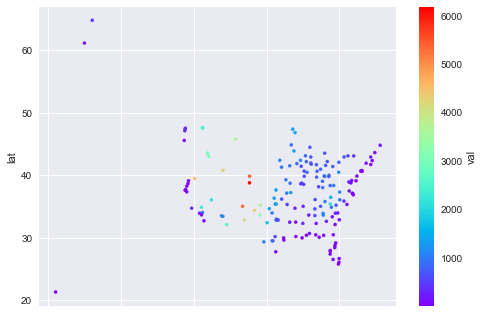

In [7]:
airportLocDF = spark.sql("""SELECT FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))) AS lon,
                                    FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))) AS lat,
                                    elevation_ft AS val
                        FROM airports 
                        WHERE type = 'large_airport' AND continent = 'NA' AND iso_country = 'US'""")

print('Plotting airport location - using altitude for different color')
airportLocPD = airportLocDF.toPandas()
airportLocPD.plot(x="lon",y="lat",c="val",s=10,cmap="rainbow",kind="scatter")


### Public holidays

Dates of public holidays in the US.

This dataset includes the following columns:

* Date: date (format: yyyy-mm-dd)
* Holiday: name of the holiday
* WeekDay: day of week
* Month: month (1-12)
* Day: day (1-31)
* Year: year (2002-2021)

Load the dataset into holidaysDF dataframe and register holidays under view name **holidays**.


In [8]:
holidaysDF = spark.read.option("header", True).option("inferSchema",True).csv(HOLIDAYS_FILENAME)

holidaysDF.createOrReplaceTempView("holidays")

holidaysDF.show(3)


+----------+-----------+-------+-----+---+----+
|      Date|    Holiday|WeekDay|Month|Day|Year|
+----------+-----------+-------+-----+---+----+
|2004-07-04|4th of July| Sunday|    7|  4|2004|
|2005-07-04|4th of July| Monday|    7|  4|2005|
|2006-07-04|4th of July|Tuesday|    7|  4|2006|
+----------+-----------+-------+-----+---+----+
only showing top 3 rows



## Problem 0 [1 point]

We start by executing some simple statistics to compare the execution time between Spark and Pandas.


### Code: Spark

In [10]:
start_time = time.time()

flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result = spark.sql("SELECT OP_CARRIER, count(*) AS num_flights FROM flights_new GROUP BY OP_CARRIER")
result.show()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))



+----------+-----------+
|OP_CARRIER|num_flights|
+----------+-----------+
|        UA|    4826658|
|        NK|     588574|
|        AA|    6682161|
|        NW|     292400|
|        EV|    4726445|
|        B6|    2483969|
|        DL|    7841880|
|        OO|    6263052|
|        F9|     903218|
|        YV|    1063558|
|        US|    2657286|
|        MQ|    3216260|
|        OH|     577060|
|        HA|     744991|
|        XE|    1105864|
|        G4|      96221|
|        YX|     316090|
|        AS|    1660539|
|        FL|    1218389|
|        CO|     740498|
+----------+-----------+
only showing top 20 rows

Runtime = 104.44895696640015


* Execution time for sample.csv: <b>6.0630</b>
* Execution time for complete.csv: <b>105.2344</b>

Using GPU @ Colab (go to Execution time menu and change the type of execution time to include GPU):

* Execution time for sample.csv: <b>10.7719</b>
* Execution time for complete.csv: <b>199.7952</b>


### Code: Pandas library

In [22]:
import pandas as pd
import time

start_time = time.time()
mySchema = {"FL_DATE": "str",
            "OP_CARRIER": "str",
            "OP_CARRIER_FL_NUM":"Int64",
            "ORIGIN":"str",
            "DEST":"str",
            "CRS_DEP_TIME":"str",
            "DEP_TIME":"str",
            "DEP_DELAY":"Int64",
            "TAXI_OUT":"Int64",
            "WHEELS_OFF":"str",
            "WHEELS_ON":"str",
            "TAXI_IN":"Int64",
            "CRS_ARR_TIME":"str",
            "ARR_TIME":"str",
            "ARR_DELAY":"Int64",
            "CANCELLED":"Int64",
            "CANCELLATION_CODE":"str",
            "DIVERTED":"Int64",
            "CRS_ELAPSED_TIME":"Int64",
            "ACTUAL_ELAPSED_TIME":"Int64",
            "AIR_TIME":"Int64",
            "DISTANCE":"Int64",
            "CARRIER_DELAY":"Int64",
            "WEATHER_DELAY":"Int64",
            "NAS_DELAY":"Int64",
            "SECURITY_DELAY":"Int64",
            "LATE_AIRCRAFT_DELAY":"Int64"
           }

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)
result = dataframe[["FL_DATE","OP_CARRIER"]].groupby("OP_CARRIER").count()
print(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


             FL_DATE
OP_CARRIER          
9E           1066251
AA           6682161
AS           1660539
B6           2483969
CO            740498
DL           7841880
EV           4726445
F9            903218
FL           1218389
G4             96221
HA            744991
MQ           3216260
NK            588574
NW            292400
OH            577060
OO           6263052
UA           4826658
US           2657286
VX            389060
WN          12096540
XE           1105864
YV           1063558
YX            316090
Runtime = 1502.589280128479


* Execution time for sample.csv: <b>27.5704</b>
* Execution time for complete.csv: <b>1502.5893</b>

**Discuss the results you have obtained:**
Using Spark to read dataframes and perform dataframe queries is significantly faster than Pandas as Pandas dataframes are not distributed whereas Spark dataframes are. This means that for large amounts of data, such as with the flights dataframes, one benefits from parallel processing using Spark which translates into faster processing of data. 

## Problem 1 [4 points]

In this first problem, you should compute a set of statistics on the data.


### Top-20 airports with more flights (include the name of the airport)

In [24]:
dfTop20AirportsDepartures = spark.sql("SELECT f.ORIGIN AS CODE, FIRST(a.name) AS NAME, COUNT(f.ORIGIN) AS N_OF_DEPARTURES FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code GROUP BY CODE ORDER BY COUNT(f.ORIGIN) DESC")
print("Top 20 airports with more flights departing")
dfTop20AirportsDepartures.show(20)

dfTop20AirportsArriving = spark.sql("SELECT f.DEST AS CODE, FIRST(a.name) AS NAME, COUNT(f.DEST) AS N_OF_ARRIVALS FROM flights f INNER JOIN airports a ON f.DEST = a.iata_code GROUP BY CODE ORDER BY COUNT(f.DEST) DESC")
print("Top 20 airports with more flights arriving")
dfTop20AirportsArriving.show(20)


Top 20 airports with more flights departing
+----+--------------------+---------------+
|CODE|                NAME|N_OF_DEPARTURES|
+----+--------------------+---------------+
| ATL|Hartsfield Jackso...|         147589|
| ORD|Chicago O'Hare In...|         115049|
| DFW|Dallas Fort Worth...|          95641|
| DEN|Denver Internatio...|          89928|
| LAX|Los Angeles Inter...|          83685|
| PHX|Phoenix Sky Harbo...|          63831|
| IAH|George Bush Inter...|          63593|
| SFO|San Francisco Int...|          63054|
| LAS|McCarran Internat...|          55333|
| MSP|Minneapolis-St Pa...|          51510|
| DTW|Detroit Metropoli...|          50049|
| CLT|Charlotte Douglas...|          49649|
| SEA|Seattle Tacoma In...|          49358|
| MCO|Orlando Internati...|          47001|
| BOS|General Edward La...|          45297|
| SLC|Salt Lake City In...|          44270|
| EWR|Newark Liberty In...|          44131|
| JFK|John F Kennedy In...|          41925|
| LGA|  La Guardia Airport|     

### Top-20 days with more flights

In [25]:
dfTop20DaysWithMoreFlights = spark.sql("SELECT FL_DATE AS DATE, COUNT(*) as N_OF_FLIGHTS from flights GROUP BY FL_DATE ORDER BY COUNT(*) DESC")
print("Top 20 days with more flights")
dfTop20DaysWithMoreFlights.show(20)

Top 20 days with more flights
+----------+------------+
|      DATE|N_OF_FLIGHTS|
+----------+------------+
|2018-07-13|       22022|
|2018-07-12|       21966|
|2018-07-09|       21956|
|2018-07-11|       21736|
|2018-07-10|       21628|
|2018-07-15|       21262|
|2018-07-08|       21251|
|2018-07-06|       20393|
|2018-07-01|       19985|
|2018-07-02|       19727|
|2018-07-05|       19649|
|2009-07-10|       19425|
|2009-07-02|       19399|
|2013-07-12|       19391|
|2009-07-09|       19377|
|2009-07-06|       19362|
|2013-07-08|       19361|
|2009-07-13|       19356|
|2013-07-15|       19354|
|2013-07-11|       19349|
+----------+------------+
only showing top 20 rows



### Periods with more flights: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)

In [26]:
print("Periods (morning, midday and evening) and their number of scheduled flights")

dfMorningFlights = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS from flights WHERE CRS_DEP_TIME >= '00:00' AND CRS_DEP_TIME <= '11:59'")
dfMorningFlights.show()

dfMiddayFlights = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS from flights WHERE CRS_DEP_TIME >= '12:00' AND CRS_DEP_TIME <= '17:59'")
dfMiddayFlights.show()

dfEveningFlights = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS from flights WHERE CRS_DEP_TIME >= '18:00' AND CRS_DEP_TIME <= '23:59'")
dfEveningFlights.show()


print("Periods (morning, midday and evening) and their number of flights that actually departed")

dfMorningFlights = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS from flights WHERE DEP_TIME >= '00:00' AND DEP_TIME <= '11:59'")
dfMorningFlights.show()

dfMiddayFlights = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS from flights WHERE DEP_TIME >= '12:00' AND DEP_TIME <= '17:59'")
dfMiddayFlights.show()

dfEveningFlights = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS from flights WHERE DEP_TIME >= '18:00' AND DEP_TIME <= '23:59'")
dfEveningFlights.show()


Periods (morning, midday and evening) and their number of scheduled flights
+-------+------------+
|Morning|N_OF_FLIGHTS|
+-------+------------+
|Morning|      981231|
+-------+------------+

+------+------------+
|Midday|N_OF_FLIGHTS|
+------+------------+
|Midday|      865053|
+------+------------+

+-------+------------+
|Evening|N_OF_FLIGHTS|
+-------+------------+
|Evening|      517320|
+-------+------------+

Periods (morning, midday and evening) and their number of flights that actually departed
+-------+------------+
|Morning|N_OF_FLIGHTS|
+-------+------------+
|Morning|      969080|
+-------+------------+

+------+------------+
|Midday|N_OF_FLIGHTS|
+------+------------+
|Midday|      824862|
+------+------------+

+-------+------------+
|Evening|N_OF_FLIGHTS|
+-------+------------+
|Evening|      539024|
+-------+------------+



### Top-20 airports with longer delays

In [27]:
dfTop20AirportsLongerDepartureDelays = spark.sql("SELECT f.ORIGIN AS CODE, FIRST(a.name) AS NAME, SUM(f.DEP_DELAY) AS TOTAL_DELAY, AVG(f.DEP_DELAY) AS AVG_DEPARTURE_DELAY FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code GROUP BY f.ORIGIN ORDER BY AVG(f.DEP_DELAY) DESC")
print("Top 20 airports with longer average delay for departures")
dfTop20AirportsLongerDepartureDelays.show(20)

dfTop20AirportsLongerArrivalDelays = spark.sql("SELECT f.DEST AS CODE, FIRST(a.name) AS NAME, SUM(f.ARR_DELAY) AS TOTAL_DELAY, AVG(f.ARR_DELAY) AS AVG_ARRIVAL_DELAY FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code GROUP BY f.DEST ORDER BY AVG(f.ARR_DELAY) DESC")
print("Top 20 airports with longer average delay for arrivals")
dfTop20AirportsLongerArrivalDelays.show(20)


Top 20 airports with longer average delay for departures
+----+--------------------+-----------+-------------------+
|CODE|                NAME|TOTAL_DELAY|AVG_DEPARTURE_DELAY|
+----+--------------------+-----------+-------------------+
| HGR|Hagerstown Region...|        561| 62.333333333333336|
| IFP|Laughlin Bullhead...|        612|               40.8|
| OGD|Ogden Hinckley Ai...|        153|              38.25|
| UST|Northeast Florida...|       1173|  35.54545454545455|
| CEC|Jack Mc Namara Fi...|       6911|   34.7286432160804|
| HYA|Barnstable Munici...|       2497|  33.74324324324324|
| BLV|Scott AFB/Midamer...|       2280| 33.529411764705884|
| LCK|Rickenbacker Inte...|       2078| 31.484848484848484|
| OGS|Ogdensburg Intern...|        118|               29.5|
| PSM|Portsmouth Intern...|        469|            29.3125|
| SLN|Salina Municipal ...|       1079|  29.16216216216216|
| OTH|Southwest Oregon ...|       7834| 26.377104377104377|
| MVY|Martha's Vineyard...|       6039| 25.

### Top 10 carriers with longer delays

In [28]:
dfTop10CarriersWithLongerDelaysDepartures = spark.sql("SELECT OP_CARRIER, COUNT(*) AS N_OF_FLIGHTS, SUM(DEP_DELAY) AS TOTAL_DELAY_DEPARTURES, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DELAY_DEPARTURES FROM flights GROUP BY OP_CARRIER ORDER BY AVG_DELAY_DEPARTURES DESC")
print("Top 10 carriers with longer average delay for departures")
dfTop10CarriersWithLongerDelaysDepartures.show(10)

dfTop10CarriersWithLongerDelaysArrivals = spark.sql("SELECT OP_CARRIER, COUNT(*) AS N_OF_FLIGHTS, SUM(ARR_DELAY) AS TOTAL_DELAY_ARRIVALS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_DELAY_ARRIVALS FROM flights GROUP BY OP_CARRIER ORDER BY AVG_DELAY_ARRIVALS DESC")
print("\n\nTop 10 carriers with longer average delay for arrivals")
dfTop10CarriersWithLongerDelaysArrivals.show(10)


Top 10 carriers with longer average delay for departures
+----------+------------+----------------------+--------------------+
|OP_CARRIER|N_OF_FLIGHTS|TOTAL_DELAY_DEPARTURES|AVG_DELAY_DEPARTURES|
+----------+------------+----------------------+--------------------+
|        G4|        5123|                103978|  20.296310755416748|
|        B6|       97885|               1609586|  16.443643050518464|
|        UA|      192622|               3083528|  16.008181827620938|
|        EV|      185522|               2945287|  15.875675122087946|
|        F9|       36190|                571738|  15.798231555678365|
|        VX|       15862|                236575|   14.91457571554659|
|        NK|       25439|                355062|  13.957388262117222|
|        WN|      465495|               5829462|  12.523146328102342|
|        AA|      266003|               3326410|  12.505159716243801|
|        FL|       43105|                521860|  12.106716158218305|
+----------+------------+--------

### Longer delays by period: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)


In [29]:
print("Average delays by period for departure")

dfMorningFlightsDelays = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DEPARTURE_DELAY from flights WHERE CRS_DEP_TIME >= '00:00' AND CRS_DEP_TIME <= '11:59'")
dfMorningFlightsDelays.show()

dfMiddayFlightsDelays = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DEPARTURE_DELAY from flights WHERE CRS_DEP_TIME >= '12:00' AND CRS_DEP_TIME <= '17:59'")
dfMiddayFlightsDelays.show()

dfEveningFlightsDelays = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DEPARTURE_DELAY from flights WHERE CRS_DEP_TIME >= '18:00' AND CRS_DEP_TIME <= '23:59'")
dfEveningFlightsDelays.show()

print("\n\nAverage delays by period for arrivals, according to departure time")

dfMorningFlightsDelays = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_ARRIVAL_DELAY from flights WHERE CRS_DEP_TIME >= '00:00' AND CRS_DEP_TIME <= '11:59'")
dfMorningFlightsDelays.show()

dfMiddayFlightsDelays = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_ARRIVAL_DELAY from flights WHERE CRS_DEP_TIME >= '12:00' AND CRS_DEP_TIME <= '17:59'")
dfMiddayFlightsDelays.show()

dfEveningFlightsDelays = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_ARRIVAL_DELAY from flights WHERE CRS_DEP_TIME >= '18:00' AND CRS_DEP_TIME <= '23:59'")
dfEveningFlightsDelays.show()


Average delays by period for departure
+-------+------------+-------------------+
|Morning|N_OF_FLIGHTS|AVG_DEPARTURE_DELAY|
+-------+------------+-------------------+
|Morning|      981231|   4.77306363129579|
+-------+------------+-------------------+

+------+------------+-------------------+
|Midday|N_OF_FLIGHTS|AVG_DEPARTURE_DELAY|
+------+------------+-------------------+
|Midday|      865053| 14.239094020828782|
+------+------------+-------------------+

+-------+------------+-------------------+
|Evening|N_OF_FLIGHTS|AVG_DEPARTURE_DELAY|
+-------+------------+-------------------+
|Evening|      517320| 19.822545039820614|
+-------+------------+-------------------+



Average delays by period for arrivals, according to departure time
+-------+------------+-----------------+
|Morning|N_OF_FLIGHTS|AVG_ARRIVAL_DELAY|
+-------+------------+-----------------+
|Morning|      981231|0.596434478731308|
+-------+------------+-----------------+

+------+------------+------------------+
|M

## Problem 2 [4 points]

Assume you want to create a web site to help travellers get information about flight delays. The web site would allow a user to find out information about delays for the flight she want to take. 
The information about delays should include at least 3 statistics - suggestion: the average delay in the same route of the same carrier in the last 7 days, 30 days, 365 days, similar but considering only flights in the same week day, similar but considering flights in the same week day, but excluding holidays, etc.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user.

Write the code to build these indices - for each index, print 5 lines.

In [447]:
groupedDelays = spark.sql("SELECT FL_DATE, FIRST(OP_CARRIER) AS OP_CARRIER, FIRST(ORIGIN) AS ORIGIN, FIRST(DEST) AS DEST, AVG(DEP_DELAY) AS DEP_DELAY from flights GROUP BY FL_DATE, OP_CARRIER, ORIGIN, DEST ORDER BY FL_DATE DESC")
groupedDelays.createOrReplaceTempView("grouped_delays")


In [450]:
dfDelaysMA = spark.sql("SELECT FL_DATE, FIRST(OP_CARRIER) AS OP_CARRIER, FIRST(ORIGIN) AS ORIGIN, FIRST(DEST) AS DEST, AVG(FIRST(DEP_DELAY)) OVER (ORDER BY FL_DATE ASC ROWS BETWEEN 7 PRECEDING AND CURRENT ROW) AS MovingAverageSevenDays, AVG(FIRST(DEP_DELAY)) OVER (ORDER BY FL_DATE ASC ROWS BETWEEN 30 PRECEDING AND CURRENT ROW) AS MovingAverageThirtyDays, AVG(FIRST(DEP_DELAY)) OVER (ORDER BY FL_DATE ASC ROWS BETWEEN 365 PRECEDING AND CURRENT ROW) AS MovingAverage365Days from grouped_delays GROUP BY FL_DATE, OP_CARRIER, ORIGIN, DEST ORDER BY FL_DATE DESC")
dfDelaysMA.show(5)

+----------+----------+------+----+----------------------+-----------------------+--------------------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|MovingAverageSevenDays|MovingAverageThirtyDays|MovingAverage365Days|
+----------+----------+------+----+----------------------+-----------------------+--------------------+
|2018-07-15|        9E|   ACK| LGA|                8.6875|      7.376344086021506| 0.39492258652094714|
|2018-07-15|        9E|   ATL| BHM|               10.8375|      6.882795698924731|  0.5411885245901638|
|2018-07-15|        9E|   AGS| ATL|                   6.0|      7.521505376344087| 0.42634335154826947|
|2018-07-15|        9E|   ATL| AGS|                7.8375|      7.076344086021505| 0.46923952641165745|
|2018-07-15|        9E|   ATL| ATW|                9.3375|      7.495698924731183|  0.5211520947176685|
+----------+----------+------+----+----------------------+-----------------------+--------------------+
only showing top 5 rows



#### Discussion

**Explain your code and discuss results**

## Problem 3 [4 points]

Transform the flights data to include a class, depending on the delay - SHORT, LONG - depending on whether the departure delay was less than 10 minutes, or greater or equal to 10 minutes.

Build and evaluate a classification model for the data.


In [27]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score
import seaborn as sns
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dfLongShort = spark.sql("SELECT FL_DATE, OP_CARRIER, ORIGIN, DEST, CRS_DEP_TIME, DEP_DELAY FROM flights LIMIT 1000000")

#0 is for SHORT delay, 1 is for LONG delay
dfLongShort = dfLongShort.withColumn("IS_LONG_DELAY", when(col("DEP_DELAY") < 10, 0).otherwise(1))

#Create MONTH column
dfLongShort = dfLongShort.withColumn("MONTH", date_format(col("FL_DATE"), "MM"))

#Create DAY column
dfLongShort = dfLongShort.withColumn("DAY", date_format(col("FL_DATE"), "dd"))

#Cast to Integer MONTH and DAY columns and remove FL_DATE column
dfLongShort = dfLongShort.withColumn("MONTH", dfLongShort["MONTH"].cast(IntegerType()))
dfLongShort = dfLongShort.withColumn("DAY", dfLongShort["DAY"].cast(IntegerType()))
dfLongShort = dfLongShort.drop("FL_DATE")

#Create PERIOD Column based on the period of the day the flight was scheduled to
dfLongShort = dfLongShort.withColumn(
    'PERIOD',
    when((col("CRS_DEP_TIME") >= '00:00') & (col("CRS_DEP_TIME") <= '05:59'), 0)\
    .when((col("CRS_DEP_TIME") >= '06:00') & (col("CRS_DEP_TIME") <= '11:59'), 1)\
    .when((col("CRS_DEP_TIME") >= '12:00') & (col("CRS_DEP_TIME") <= '15:59'), 2)\
    .when((col("CRS_DEP_TIME") >= '16:00') & (col("CRS_DEP_TIME") <= '19:59'), 3)\
    .otherwise(4)
)


dfLongShort = dfLongShort.drop("CRS_DEP_TIME")

#Transform string values of OP_CARRIER, ORIGIN and DEST to numerical values so it can be used as features for the model
carrier_indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_INDEX")
dfLongShort = carrier_indexer.fit(dfLongShort).transform(dfLongShort)
origin_indexer = StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_INDEX")
dfLongShort = origin_indexer.fit(dfLongShort).transform(dfLongShort)
dest_indexer = StringIndexer(inputCol="DEST", outputCol="DEST_INDEX")
dfLongShort = dest_indexer.fit(dfLongShort).transform(dfLongShort)

dfLongShort = dfLongShort.drop("OP_CARRIER")
dfLongShort = dfLongShort.drop("ORIGIN")
dfLongShort = dfLongShort.drop("DEST")

#One hot encoder for fields with categorical nature
encoder = OneHotEncoder(inputCols=["PERIOD", "OP_CARRIER_INDEX", "ORIGIN_INDEX", "DEST_INDEX"], outputCols=["PERIOD_ENCOD", "OP_CARRIER_ENCOD", "ORIGIN_ENCOD", "DEST_ENCOD"])
dfLongShort = encoder.fit(dfLongShort).transform(dfLongShort)

#Create array of features and define input and output variables
assembler = VectorAssembler(inputCols=["MONTH", "DAY", "PERIOD_ENCOD", "OP_CARRIER_ENCOD", "ORIGIN_ENCOD", "DEST_ENCOD"], outputCol="features")
output = assembler.transform(dfLongShort)
output = output.select(col("features"), col("IS_LONG_DELAY").alias("label"))

#Split train and test set
train, test = output.randomSplit([0.7, 0.3], seed=123)


In [28]:
logModel = LogisticRegression(labelCol="label").fit(train)

In [29]:
summary = logModel.summary

print(f"Accuracy Score for Logistic Regression (Training Set): {summary.accuracy}")
print(f"ROC-AUC Score for Logistic Regression (Training Set): {summary.areaUnderROC}")
print(f"Weighted F1-Score for Logistic Regression (Training Set): {summary.weightedFMeasure()}")

Accuracy Score for Logistic Regression (Training Set): 0.7472097272781866
ROC-AUC Score for Logistic Regression (Training Set): 0.6857530376240283
Weighted F1-Score for Logistic Regression (Training Set): 0.6638056596856362


In [30]:
pred = logModel.evaluate(test)

In [31]:
print(f"Accuracy Score for Logistic Regression (Test Set): {pred.accuracy}")
print(f"ROC Score for Logistic Regression (Test Set): {pred.areaUnderROC}")
print(f"Weighted F1-Score for Logistic Regression (Test Set): {pred.weightedFMeasure()}")

Accuracy Score for Logistic Regression (Test Set): 0.747446824082021
ROC Score for Logistic Regression (Test Set): 0.6818898143357056
Weighted F1-Score for Logistic Regression (Test Set): 0.6641627463422044


In [39]:
pred.predictions.createOrReplaceTempView("predictions")

In [50]:
dfPredictions = spark.sql("SELECT SUM(CASE WHEN (label=0 AND prediction=0) THEN 1 ELSE 0 END) AS T_N, SUM(CASE WHEN (label=1 AND prediction=0) THEN 1 ELSE 0 END) AS F_N, SUM(CASE WHEN (label=0 AND prediction=1) THEN 1 ELSE 0 END) AS F_P, SUM(CASE WHEN (label=1 AND prediction=1) THEN 1 ELSE 0 END) AS T_P FROM predictions")
dfPredictions = dfPredictions.toPandas()

/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [65]:
array_confusion = dfPredictions.iloc[0]

print("Predicted\t\t0\t\t1")
print(f"Actual\n0\t\t      {array_confusion[0]}\t      {array_confusion[1]}\n1\t\t      {array_confusion[2]}\t      {array_confusion[3]}")


Predicted		0		1
Actual
0		      219791	      71861
1		      4058	      4896


#### Discussion

**Explain your code and discuss results**

## Problem 4 [4 points]

Consider we want to cluster airports depending on their properties, such as average number of flights per day, delays, cancellations, etc.

Measure the quality of your clustering result.

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler

dfAirports = spark.sql("SELECT f.ORIGIN AS CODE, FIRST(a.name) AS NAME, FIRST(a.type) AS TYPE, COUNT(f.ORIGIN)/COUNT(DISTINCT f.FL_DATE) AS FLIGHTS_PER_DAY, SUM(f.CANCELLED) AS FLIGHTS_CANCELLED, AVG(f.AIR_TIME) AS FLIGHT_DURATION_AVG, AVG(f.DISTANCE) AS FLIGHT_DISTANCE_AVG FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code GROUP BY CODE LIMIT 100")

type_indexer = StringIndexer(inputCol="TYPE", outputCol="TYPE_INDEX")
dfAirports = type_indexer.fit(dfAirports).transform(dfAirports)

dfAirports = dfAirports.drop("TYPE")

listColumns = ["FLIGHTS_PER_DAY", "FLIGHTS_CANCELLED", "FLIGHT_DURATION_AVG", "FLIGHT_DISTANCE_AVG"]

assembler = VectorAssembler(inputCols=listColumns, outputCol="features")
output = assembler.transform(dfAirports)

scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)
scaled_output = scaler.fit(output).transform(output)

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features_scaled", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_scores = []

for i in range(2,8):
    kmeans = KMeans(featuresCol="features_scaled", k=i)
    kmeans_fit = kmeans.fit(scaled_output)
    final_output = kmeans_fit.transform(scaled_output)
    score = evaluator.evaluate(final_output)
    silhouette_scores.append(score)
    
    print(f"Silhouette score for K{i}: {score}")

Silhouette score for K2: 0.7246810522069047
Silhouette score for K3: 0.7701325175988071
Silhouette score for K4: 0.7871707496917884
Silhouette score for K5: 0.5858584493756787
Silhouette score for K6: 0.5205522943727667
Silhouette score for K7: 0.5457650489177809


Text(0, 0.5, 'Score')

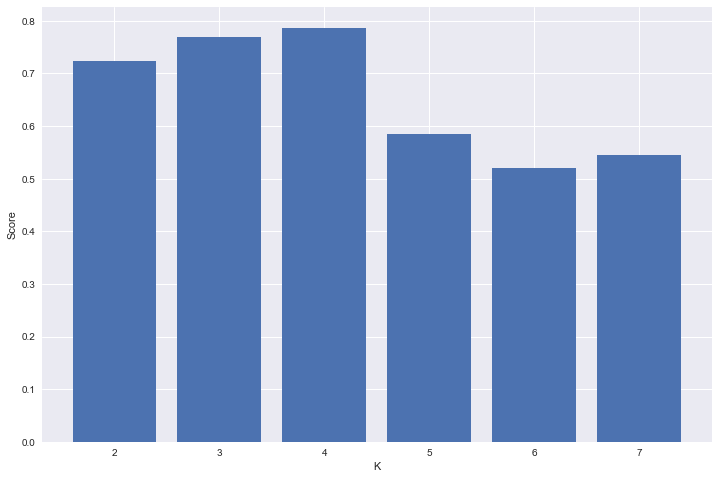

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.bar(range(2,8), np.array(silhouette_scores))
ax.set_xlabel("K")
ax.set_ylabel("Score")

#### Discussion

**Explain your code and discuss results**

## Problem 5 [3 points]

We now want to find communities of airports, i.e., airports that are connected based on the flights that exist.

Propose an algorithm to solve this problem and plot the communities as a graph. Run the program with and without GPU support.

In [399]:
from graphframes import *
from graphframes.examples import Graphs
from pyspark import *
from pyspark.sql import *

In [366]:
originsDistinct = spark.sql("SELECT DISTINCT ORIGIN AS AIRPORT FROM flights LIMIT 100")
destinationsDistinct = spark.sql("SELECT DISTINCT DEST AS AIRPORT FROM flights LIMIT 100")
flightsDistinct = spark.sql("SELECT DISTINCT (ORIGIN, DEST) AS AIRPORT FROM flights LIMIT 100")
airportsDistinct = originsDistinct.union(destinationsDistinct).dropDuplicates()
airportsDistinct.show()

+-------+
|AIRPORT|
+-------+
|    BGM|
|    DLG|
|    PSE|
|    INL|
|    MSY|
|    PPG|
|    GEG|
|    DRT|
|    BUR|
|    SNA|
|    GRB|
|    GTF|
|    IFP|
|    IDA|
|    GRR|
|    LWB|
|    JLN|
|    PVU|
|    PSG|
|    EUG|
+-------+
only showing top 20 rows



In [367]:
flightsDistinct.show()

+----------+
|   AIRPORT|
+----------+
|{MCI, IAH}|
|{ROC, CLE}|
|{SNA, PHX}|
|{SPI, ORD}|
|{ATL, GSP}|
|{BQN, MCO}|
|{EWR, STT}|
|{FSD, ATL}|
|{MLI, MCO}|
|{PHL, MCO}|
|{LAX, OXR}|
|{ORD, PDX}|
|{PBI, DCA}|
|{LAS, LIT}|
|{SMF, BUR}|
|{CLE, SJU}|
|{AMA, MEM}|
|{DSM, MCO}|
|{TYS, MIA}|
|{MCI, MKE}|
+----------+
only showing top 20 rows



#### Discussion

**Explain your code and discuss results**